In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from src.utils import set_seed
import torch
from src.model_bert import Vola_BERT
from src.trainer import Trainer
from src.dataset import Dataset_Rates_30M

## Model Training

In [2]:
trainset = Dataset_Rates_30M(root_path='./data', flag='train', rates=("gbp", "usd"),
                           size=(40, 5), target="vola", features="MS", use_explainable=True)
valset = Dataset_Rates_30M(root_path='./data', flag='val', rates=("gbp", "usd"),
                           size=(40, 5), target="vola", features="MS", use_explainable=True)
testset = Dataset_Rates_30M(root_path='./data', flag='test', rates=("gbp", "usd"),
                           size=(40, 5), target="vola", features="MS", use_explainable=True)
len(trainset), len(valset), len(testset)

(30107, 6494, 6668)

In [3]:
model = Vola_BERT(
          **{
              'input_len':40,
              'pred_len':5,
              'n_layer':4,
              'num_series': 21,
              'semantic_tokens': {'market_session': 5, 'event': 3}
          }
        )

In [4]:
trainer = Trainer(model, use_amp=True, features="MS", num_workers=6, save_path="checkpoints/vola_bert_example",
                      patience=20, verbose=False)

Path checkpoints/vola_bert_example not exists, creating...


In [5]:
import time
start = time.time()

trainer.train(trainset, valset, batch_size=200, max_epochs=400, lr=1e-3)

training_secs = int(time.time() - start)
print(f"Finished training. Takes {training_secs//60}m{training_secs%60}s")

/vol/bitbucket/qn24/vola-bert-public/src/trainer.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
/vol/bitbucket/qn24/vola-bert-public/src/trainer.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Finished training. Takes 9m9s


In [6]:
print("Validation MAE:", trainer.test(valset, batch_size=200))
print("Test MAE:", trainer.test(testset, batch_size=200))

Validation MAE: 0.3147210623278762
Test MAE: 0.2817448219832252


## Explainability Evaluation

In [7]:
import matplotlib.pyplot as plt
from src.plot_utils import tuple_unsqueeze, inv_transform, plot_predictions
import pickle

In [8]:
# Loads example models
model = Vola_BERT(
          **{
              'input_len':40,
              'pred_len':5,
              'n_layer':4,
              'num_series': 21,
              'semantic_tokens': {'market_session': 5, 'event': 3}
          }
        ).to("cuda")
model.load_state_dict(torch.load("checkpoints/vola_bert_example/checkpoint.pth"))
model.eval()

Vola_BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

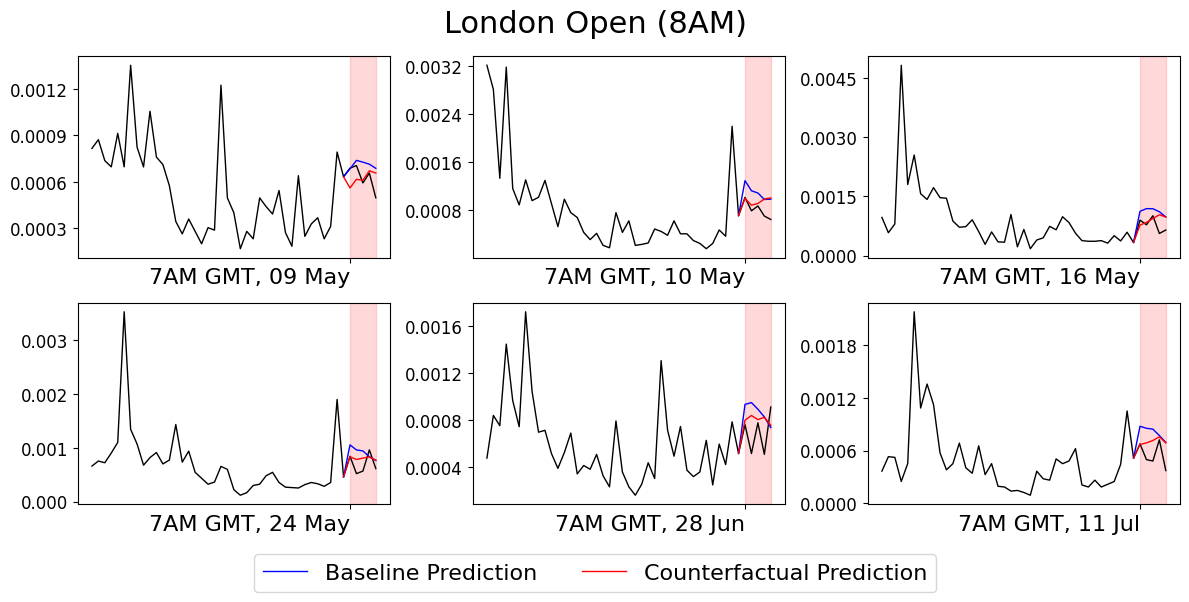

In [13]:
# Loads timepoint examples for FOMC Press Conference
with open("examples/london_open.pkl", "rb") as f:
    y_dts, london_open_data = pickle.load(f)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
model.eval()
for i in range(len(y_dts)):

    x, y = london_open_data[i]
    y_pred = model(tuple_unsqueeze(x))[0][0]
    
    assert(x[1]["market_session"].item() == 4)  # London opening hours

    base_tokens = {"market_session": torch.tensor(0, dtype=torch.long), "event": x[1]["event"].clone()}
    base_x = (x[0].clone(), base_tokens)
    y_base = model(tuple_unsqueeze(base_x))[0][0]

    y_dt = y_dts[i]
    
    plot_predictions(axs[i], 
                 inv_transform(x[0][-1, :].numpy()),
                 inv_transform(y[0].numpy()),
                 inv_transform(y_pred.cpu().detach().numpy()),
                 inv_transform(y_base.cpu().detach().numpy()), title=None,
                 xticks_label=y_dt.strftime('%-I%p') + f' GMT, ' + y_dt.strftime('%d %b'))
    
# Add single legend for whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=16, bbox_to_anchor=(0.5, -0.01))


fig.suptitle("London Open (8AM)", fontsize=22)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig(f"figs/london-open.pdf", bbox_inches="tight")
plt.show()

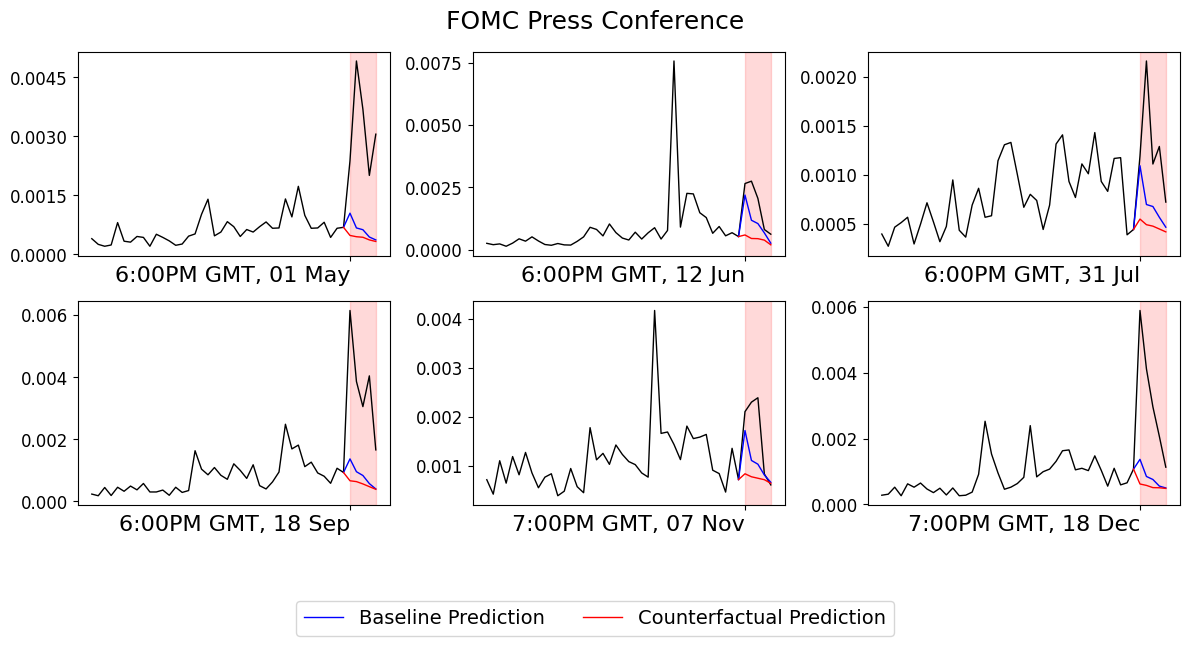

In [14]:
with open("examples/fomc_press.pkl", "rb") as f:
    y_dts, fomc = pickle.load(f)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
model.eval()
for i in range(len(y_dts)):
    
    x, y = fomc[i]
    y_pred = model(tuple_unsqueeze(x))[0][0]

    base_tokens = {"market_session": x[1]["market_session"], "event": torch.tensor(0, dtype=torch.long)}
    base_x = (x[0].clone(), base_tokens)
    y_base = model(tuple_unsqueeze(base_x))[0][0]

    y_dt = y_dts[i]
    
    plot_predictions(axs[i], 
                 inv_transform(x[0][-1, :].numpy()),
                 inv_transform(y[0].numpy()),
                 inv_transform(y_pred.cpu().detach().numpy()),
                 inv_transform(y_base.cpu().detach().numpy()), title=None,
                 xticks_label=y_dt.strftime('%-I:%M%p') + f' GMT, ' + y_dt.strftime('%d %b'))

# Add single legend for whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.08))

fig.suptitle("FOMC Press Conference", fontsize=18)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig(f"figs/news-fomc.pdf", bbox_inches="tight")
plt.show()